# Reconocimiento de dígitos con KNN



Definir los path al ejecutable de python 3.6 y sus librerías,
de acuerdo al virtual env que estén corriendo.

In [1]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version


mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc - works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ - works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/jazzer/.pyenv/versions/3.6.5/bin/python (found version "3.6.5") 
-- Found PythonLibs: /home/jazzer/.pyenv/versions/3.6.5/lib/libpython3.6m.a
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/jazzer/Facultad/metodos_numericos/mt/tp2
-- Co

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import metnum as mt
import datetime
import os
from datetime import datetime
from sklearn.neighbors import KNeighborsClassifier
from numpy import savetxt
from sklearn.metrics import accuracy_score

#percentage over total of train cases
PERCENTAGE_OF_TRAIN_CASES = 0.8
#neighbors for finding the mode in KNN
N_NEIGHBORS = 100
#components for PCA
N_COMPONENTS=40
#number of iterations to find eigenvalues and eigenvectors in power iteration
N_ITERATIONS=5000
#epsilon for power iteration
EPSILON=1e-10
#directory for saving matrix files
timestamp = datetime.now().strftime("%m_%d_%H_%M_%S")
DIRECTORY_NAME="{}".format(timestamp)
os.makedirs(DIRECTORY_NAME+"/", exist_ok=True)

%load_ext autoreload
%autoreload 2

df_train = pd.read_csv("../data/train.csv")

TOTAL_TRAIN_CASES = int(PERCENTAGE_OF_TRAIN_CASES*len(df_train))

#shuffle the train cases.
df_train = df_train[0: TOTAL_TRAIN_CASES].sample(frac=1)

# Uso values para mandar todo a arrays de numpy
X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

limit = int(0.8 * X.shape[0]) 

X_train, y_train = X[:limit], y[:limit]
X_val, y_val = X[limit:], y[limit:]

assert len(X_train) == len(y_train)
assert len(X_val) == len(y_val)

print(f"Ahora tengo {len(X_train)} instancias de entrenamiento y {len(X_val)} de validación")

Ahora tengo 26880 instancias de entrenamiento y 6720 de validación


### Opcional: guardamos las matrices de entrenamiento en un archivo si queremos reproducir el experimento

In [3]:
savetxt('{}/X_train.csv'.format(DIRECTORY_NAME), X_train, delimiter=',')
savetxt('{}/y_train.csv'.format(DIRECTORY_NAME), y_train, delimiter=',')
savetxt('{}/X_val.csv'.format(DIRECTORY_NAME), X_val, delimiter=',')
savetxt('{}/y_val.csv'.format(DIRECTORY_NAME), y_val, delimiter=',')

## Testing sin PCA (raw data)

### Entrenamos el dato con los test cases sin modificar y probamos su accuracy

In [4]:
%%time

clf = mt.KNNClassifier(N_NEIGHBORS)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_val[0:])
acc = accuracy_score(y_val, y_pred)
print("Accuracy: {}".format(acc))


Accuracy: 0.9083333333333333
CPU times: user 4min 4s, sys: 1.71 s, total: 4min 6s
Wall time: 4min 8s


### Ejemplo para probar la capacidad del modelo a mano.

Prediction: 6 - Digit: 6


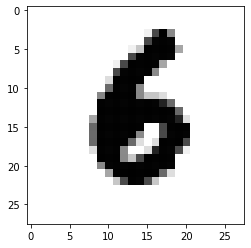

In [8]:
random_example= 598

img = X_val[random_example].reshape(28, 28)
plt.imshow(img, cmap="Greys")

print("Prediction: {} - Digit: {}".format( int(y_pred[random_example]), int(y_val[random_example])))

## Testing con PCA

### Usamos PCA para transformar la data

In [12]:
%%time
pca = mt.PCA(N_COMPONENTS, N_ITERATIONS, EPSILON)
pca.fit(X_train)

X_train_pca, X_val_pca = pca.transform(X_train), pca.transform(X_val)


CPU times: user 6.26 s, sys: 424 ms, total: 6.68 s
Wall time: 6.67 s


### Opcional: guardamos las matrices de entrenamiento en un archivo si queremos reproducir el experimento

In [6]:
savetxt('{}/X_train_pca.csv'.format(DIRECTORY_NAME), X_train_pca, delimiter=',')
savetxt('{}/X_val_pca.csv'.format(DIRECTORY_NAME), X_val_pca, delimiter=',')

### Entrenamos el modelo con la data de PCA y testeamos accuracy

In [13]:
%%time
clf = mt.KNNClassifier(N_NEIGHBORS)

clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_val_pca[0:])
acc = accuracy_score(y_val, y_pred)
print("Accuracy: {}".format(acc))

Accuracy: 0.9367559523809523
CPU times: user 32.3 s, sys: 227 ms, total: 32.5 s
Wall time: 32.7 s


# Testeo automático moviendo parámetros

In [26]:
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import metnum as mt
import datetime
import os
from datetime import datetime
from sklearn.neighbors import KNeighborsClassifier
from numpy import savetxt
from sklearn.metrics import *
from IPython.display import display, HTML

def calculate_metrics(y_val, y_pred, time):
    
    acc = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average=None)
    recall = recall_score(y_val, y_pred, average=None)
    f1 = f1_score(y_val, y_pred, average=None)
    kappa = -1#kappa_score(y_val, y_pred, average=None)
    
    return (acc, precision, recall, 
            f1, kappa, time)


def pca_experiment(PERCENTAGE_OF_TRAIN_CASES, N_NEIGHBORS, N_COMPONENTS, N_ITERATIONS, EPSILON):
    
    start = time.time()
    df_train = pd.read_csv("../data/train.csv")

    TOTAL_TRAIN_CASES = int(PERCENTAGE_OF_TRAIN_CASES*len(df_train))
    #shuffle the train cases.
    df_train = df_train[0: TOTAL_TRAIN_CASES].sample(frac=1)

    # Uso values para mandar todo a arrays de numpy
    X = df_train[df_train.columns[1:]].values
    y = df_train["label"].values.reshape(-1, 1)

    limit = int(0.8 * X.shape[0]) 

    X_train, y_train = X[:limit], y[:limit]
    X_val, y_val = X[limit:], y[limit:]
    
    pca = mt.PCA(N_COMPONENTS, N_ITERATIONS, EPSILON)
    pca.fit(X_train)

    X_train_pca, X_val_pca = pca.transform(X_train), pca.transform(X_val)
    
    clf = mt.KNNClassifier(N_NEIGHBORS)

    clf.fit(X_train_pca, y_train)

    y_pred = clf.predict(X_val_pca[0:])
    
    return calculate_metrics(y_val, y_pred, time.time()-start)



def create_df(variable, experiment_results):
    df = pd.DataFrame(columns=[variable, 'ACCURACY', 'TIME'])
    
    for i in range(10):
        df['PRECISION_'+str(i)] = np.NaN
    for i in range(10):
        df['RECALL_'+str(i)] = np.NaN
    for i in range(10):
        df['F1_'+str(i)] = np.NaN
        
    return df.append(experiment_results, sort=False)



def experiment_percentage_of_train_cases(PERCENTAGE_OF_TRAIN_CASES_RANGE, 
                                     N_NEIGHBORS, N_COMPONENTS, 
                                     N_ITERATIONS, EPSILON):
    
    timestamp = datetime.now().strftime("%m-%d-%H-%M-%S")
    
    experiment_results = []
    
    for PERCENTAGE_OF_TRAIN_CASES in PERCENTAGE_OF_TRAIN_CASES_RANGE:
        
        (acc, precision, recall, 
         f1, kappa, execution_time) =  pca_experiment(PERCENTAGE_OF_TRAIN_CASES, 
                                                      N_NEIGHBORS, N_COMPONENTS, 
                                                      N_ITERATIONS, EPSILON)
        
        data ={
            'PERCENTAGE_OF_TRAIN_CASES' : PERCENTAGE_OF_TRAIN_CASES,
            'ACCURACY' : acc,
            'TIME' : round(execution_time) 
        }
        
        for i in range(10):
            data['PRECISION_'+str(i)] = precision[i]
            data['RECALL_'+str(i)] = recall[i]
            data['F1_'+str(i)] = f1[i]
            
        experiment_results.append(data)
        
    filename='test_PERCENTAGE_OF_TRAIN_CASES-{}'.format(time.time())
    
    df_result = create_df('PERCENTAGE_OF_TRAIN_CASES', experiment_results)  
    df_result.to_csv(filename+'.csv', encoding='utf-8', index=False)
    
    metadata = {
        'N_NEIGHBORS': [N_NEIGHBORS],
        'N_COMPONENTS': [N_COMPONENTS],
        'N_ITERATIONS': [N_ITERATIONS],
        'EPSILON': [EPSILON],
        'TIMESTAMP' : [timestamp]
    } 
    df_metadata = pd.DataFrame(metadata, 
                               columns = ['N_NEIGHBORS', 'N_COMPONENTS',
                                          'N_ITERATIONS', 'EPSILON', 'TIMESTAMP'])
    df_metadata.to_csv(filename+'-metadata.csv',encoding = 'utf-8', index=False)
    
    display(metadata)
    display(df_results)

        
def main():
    #percentage over total of train cases
    PERCENTAGE_OF_TRAIN_CASES = 0.5
    #neighbors for finding the mode in KNN
    N_NEIGHBORS = 100
    #components for PCA
    N_COMPONENTS=40
    #number of iterations to find eigenvalues and eigenvectors in power iteration
    N_ITERATIONS=5000
    #epsilon for power iteration
    EPSILON=1e-10
    
    experiment_percentage_of_train_cases(np.linspace(0.1,1,3), N_NEIGHBORS, 
                                     N_COMPONENTS, N_ITERATIONS, EPSILON)

main()
